In [9]:

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import random
import math
from networkx.utils import py_random_state
import nltk

# Prepare data

In [3]:
office = pd.read_csv('/Users/Nhu/Documents/Dev/The_Office/Data/The_Office_lines.csv')

In [4]:
office['word_count'] = office['line_text'].str.split().map(len)

In [43]:
office['line_text_lower']= office['line_text'].str.lower()

### Prepare the text for NLP
### Text Normalization
Tokenization → Remove stopwords → Lemmatization 

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [7]:
office['tokenized_text'] = office['line_text'].apply(word_tokenize) 

In [29]:
description_list=[]
for description in office['line_text']:
    #Tokenize
    description=re.sub("\[[^)]*\]"," ",description)
    description=re.sub("[^a-zA-Z]", " ", description)
    description=description.lower()
    description=nltk.word_tokenize(description)
    #Filterout stopwords
    description=[word for word in description if not word in set(stopwords.words("english"))]
    #Lemmatization
    lemma=nltk.WordNetLemmatizer()
    description=[lemma.lemmatize(word,pos='v') for word in description]
    description=" ".join(description)
    description_list.append(description)
office["normalized_text_new"]=description_list

# Line, WordCount Analysis

### Which characters have the most to say?

In [11]:
# get 20 characters
main_characters = list(office['speaker'].value_counts().index[:20])

In [13]:
  
df_word_count = office[np.where(office.speaker.isin(main_characters), True, False)]\
    .groupby('speaker')\
    .agg({'word_count' : ['max', 'count','median']})
df_word_count.columns = ['max', 'count', 'med']
df_word_count.reset_index(inplace=True)
df_word_count = df_word_count.sort_values('max', ascending=False)
df_word_count = df_word_count.sort_values('count', ascending=False)

In [14]:
dftest = office.sort_values('word_count', ascending=False)
dftest.reset_index()

,index,id,season,episode,scene,line_text,speaker,deleted,word_count,tokenized_text,normalized_text_new
0,888,889,1,3,48,I've really learned from the greats. The great...,Michael,True,273,"[I, 've, really, learned, from, the, greats, ....",really learned great great improvisers drew ca...
1,16338,16339,3,22,55,[runs over after walking over fire coals] Hey!...,Pam,False,245,"[[, runs, over, after, walking, over, fire, co...",jim called wedding even friend thing like weir...
2,7874,7875,2,17,52,"Ah, look at me. I'm huge in Wilkes-Barre. Perf...",Michael,True,213,"[Ah, ,, look, at, me, ., I, 'm, huge, in, Wilk...",ah look huge wilkes barre performing nightly m...
3,14954,14955,3,18,57,"Look, I am not a gazillionaire. I can't... I ...",Michael,False,203,"[Look, ,, I, am, not, a, gazillionaire, ., I, ...",look gazillionaire dress like donald trump dre...
4,4446,4447,2,7,45,"Doctor David Friendly's Egg Yolk Diet. It's, ...",Michael,True,194,"[Doctor, David, Friendly, 's, Egg, Yolk, Diet,...",doctor david friendly egg yolk diet kind uniqu...
...,...,...,...,...,...,...,...,...,...,...,...
59904,26992,26993,5,13,50,Well...,Michael,False,1,"[Well, ...]",well
59905,11584,11585,3,8,20,Yeah.,Ryan,False,1,"[Yeah, .]",yeah
59906,11585,11586,3,8,20,Oh.,Jim,False,1,"[Oh, .]",oh
59907,43933,43934,7,19,10,Hello!,Deangelo,False,1,"[Hello, !]",hello


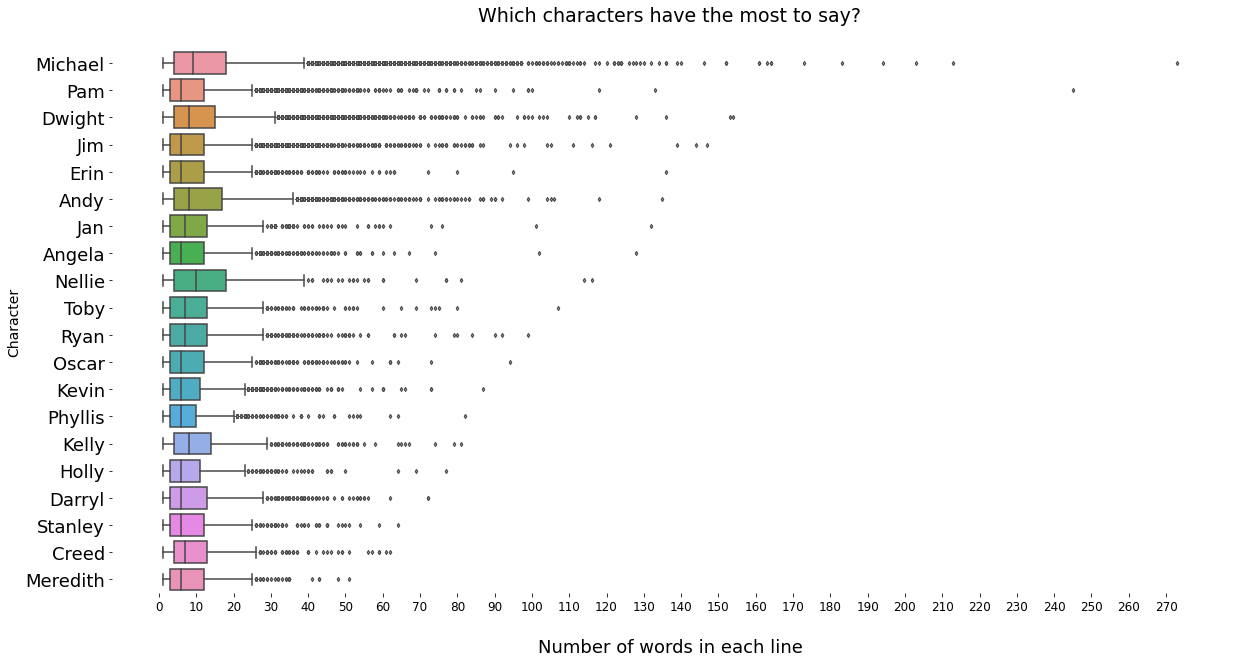

In [15]:
df_for_plot = office[np.where(office.speaker.isin(df_word_count.speaker), True, False)]
fig = plt.figure(figsize=(20,10))
#greyout outlier
flierprops = dict(markerfacecolor='0.6', markersize=3,
              linestyle='none')

ax = sns.boxplot(
    x=df_for_plot['word_count'],
    y=df_for_plot.speaker,
    flierprops=flierprops,
   
    order=df_word_count.sort_values('max', ascending=False).speaker,
#     palette=palette
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(list(range(0,275,10)), fontsize=12)
#set(xlim=(0,250))

plt.yticks(fontsize=18)
plt.xlabel(f'\nNumber of words in each line', fontsize=18)
plt.ylabel('Character', fontsize=14)
plt.title('Which characters have the most to say?\n', fontsize=19)
#plt.savefig('/Users/Nhu/Documents/Dev/The_Office/Figures/Word_count_analysis.png', bbox_inches='tight', transparent=True)

plt.show()

# plt.xticks(fontsize=18, rotation='90')
# plt.yticks(fontsize=18, rotation='0')
# plt.title(f'Who speaks to whom?',
#           fontdict={'fontsize': 20},
#           pad=24)

### Who speak the most?


In [181]:
speaker_line = dict((office['speaker'].value_counts())[:20])

In [182]:
df_speaker_line = pd.DataFrame(df_speaker_line.items(), columns = ['speaker','num_line'])
# df_speaker_line = pd.DataFrame(d.items(), columns=['Date', 'DateValue'])

In [40]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space) + 0.3
                _y = p.get_y() + p.get_height() - 0.3
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize = 14)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [843]:
def speaker_line_graph():
    fig = plt.figure(figsize=(20,10))
    ax = sns.barplot(y=df_speaker_line['speaker'], x=df_speaker_line['num_line'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(fontsize=12)
    #set(xlim=(0,250))

    plt.yticks(fontsize=18)
    plt.xlabel(f'\nNumber of line', fontsize=18)
    plt.ylabel('Character', fontsize=14)
    plt.title('Which characters talk the most?\n', fontsize=19)
    #plt.savefig('../plots/box_plot.png', bbox_inches='tight')



    show_values_on_bars(ax,"h", 0.1)
    plt.savefig('/Users/Nhu/Documents/Dev/The_Office/Figures/Line_count_analysis.png', bbox_inches='tight', transparent=True)
    plt.show()
    
    #order=df_word_count.sort_values('max', ascending=False).speaker,
#     palette=palette
    




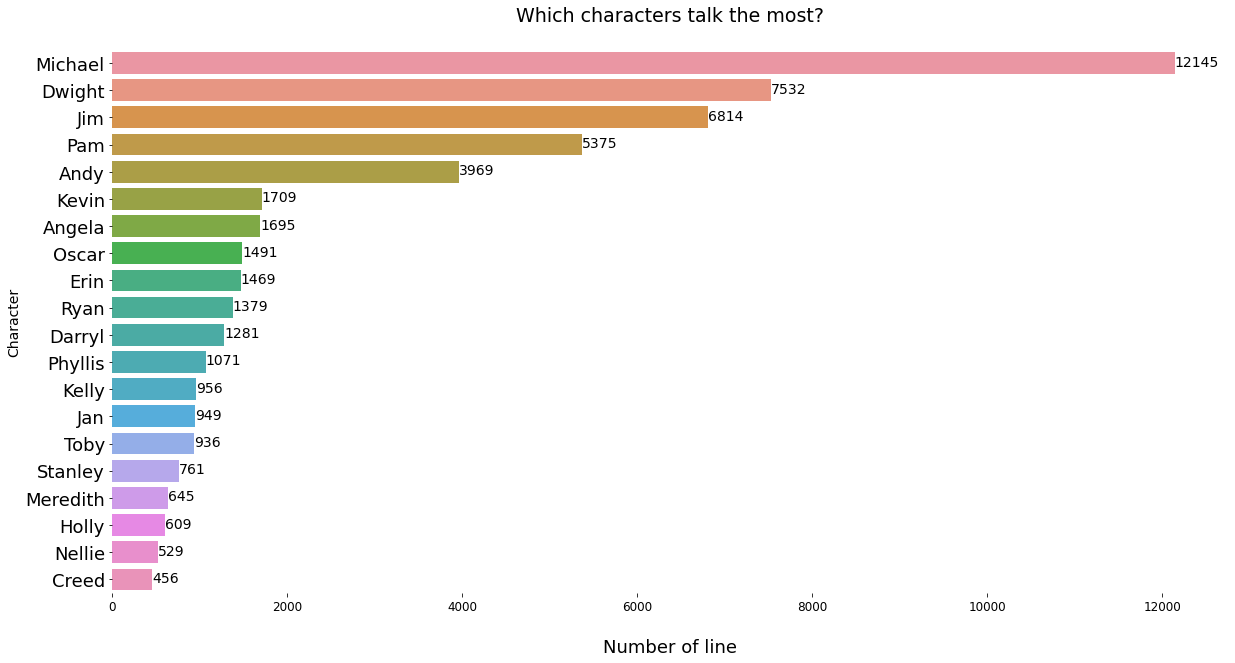

In [844]:
speaker_line_graph()

# Sentiment Analysis
There are many method about Sentiment Analysis, I choose  Rule-based lexicons with Vader model
https://medium.com/swlh/we-need-to-talk-about-sentiment-analysis-9d1f20f2ebfb


In [247]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [248]:
# def answer_three():
#     from nltk.probability import FreqDist
    
#     dist = FreqDist(moby_tokens)
    
#     return dist.most_common(20)
# answer_three()

In [249]:
sid = SentimentIntensityAnalyzer()


In [250]:
df_sentiment =  office.copy()

In [251]:
df_sentiment['sentiment'] = df_sentiment['line_text'].apply(lambda x: sid.polarity_scores(x))

In [252]:
df_sentiment['vader_compound']  = df_sentiment['sentiment'].apply(lambda score_dict: score_dict['compound'])

In [253]:
df_sentiment['vader_positive']  = df_sentiment['sentiment'].apply(lambda score_dict: score_dict['pos'])

In [254]:
df_sentiment['vader_negative']  = df_sentiment['sentiment'].apply(lambda score_dict: score_dict['neg'])

In [255]:
df_sentiment = df_sentiment[['speaker','vader_positive','vader_negative']]

In [256]:
df_ = df_sentiment.copy()
df_.groupby('speaker').mean().reset_index()

,speaker,vader_positive,vader_negative
0,(Pam's mom) Heleen,0.000000,0.000000
1,3rd Athlead Employee,0.000000,0.000000
2,4th Athlead Employee,0.415000,0.000000
3,A.J.,0.487625,0.019875
4,AJ,0.214696,0.041826
...,...,...,...
779,Zeke,0.274533,0.026467
780,Zion,0.000000,0.000000
781,abe,0.071000,0.000000
782,sAndy,0.166000,0.000000


In [257]:
df_ = df_[np.where(df_.speaker.isin(main_characters), True, False)]

In [258]:
df_ = df_.groupby('speaker').mean().reset_index()

In [259]:
df_ = df_.sort_values(by = ['vader_positive'], ascending=True)

In [262]:
def graph_sentiment():
    n = len(df_.vader_positive)
    
    
    X = np.arange(n)
    
    fig = plt.figure(figsize=(16, 16))
    ax = plt.barh(X, df_.vader_positive, facecolor='#74c69d', edgecolor='white')
    ax = plt.barh(X, -df_.vader_negative, facecolor='#ffadad', edgecolor='white')
    
    font = {'size': 18}
    matplotlib.rc('font', **font)
    
    plt.xlim([-.13, .23])
    plt.yticks(ticks=X, labels=df_.speaker, rotation='0', fontsize=18)
    plt.xlabel('Senitment Score')
    plt.title('Average Sentiment scores of The Office characters\n', fontsize=19)
    plt.legend(('Positive Sentiment', 'Negative Sentiment'))
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.savefig('/Users/Nhu/Documents/Dev/The_Office/Figures/Avg_Sent_scores.png', bbox_inches='tight', transparent=True)
    plt.show()

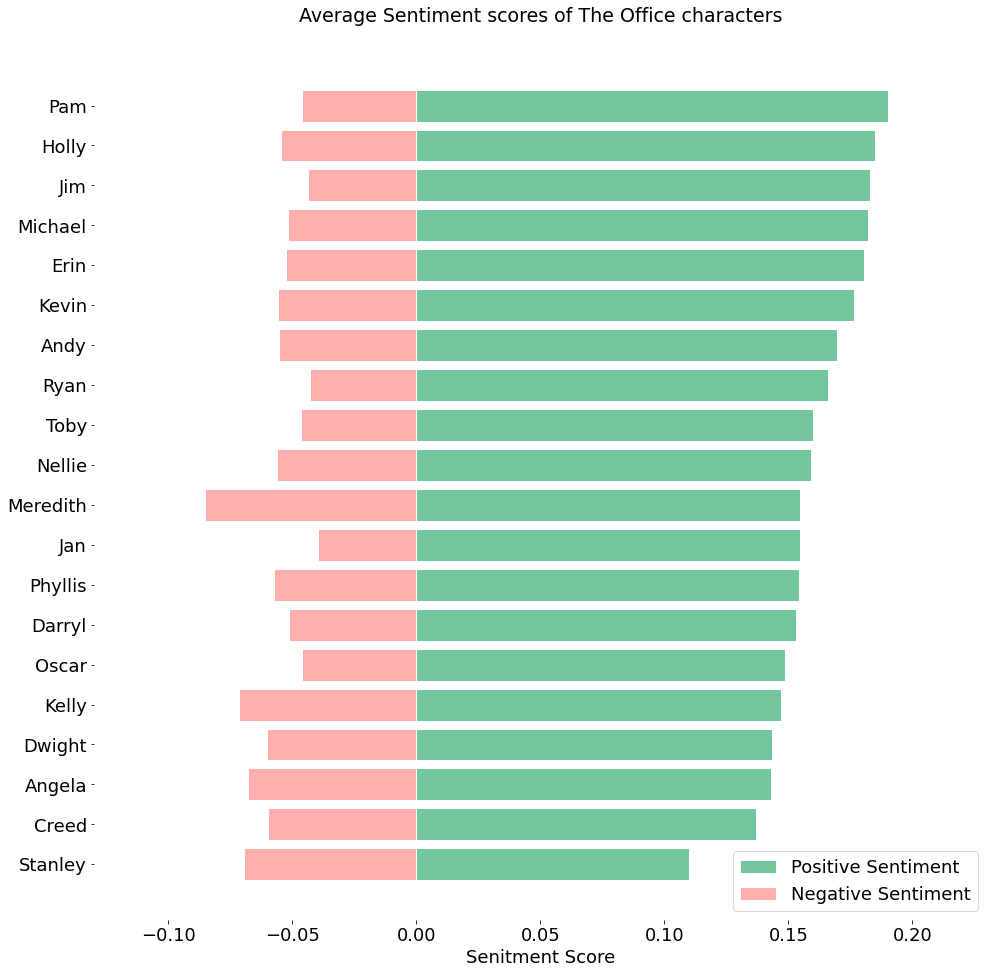

In [263]:
graph_sentiment()

# n-grams analysis

In [31]:
ngram_df = office.copy()

In [32]:
pam_df = ngram_df[ngram_df.speaker.isin(['Pam'])]
jim_df= ngram_df[ngram_df.speaker.isin(['Jim'])]
michael_df=ngram_df[ngram_df.speaker.isin(['Michael'])]
dwight_df=ngram_df[ngram_df.speaker.isin(['Dwight'])]


In [36]:
# Defining a function to visualise n-grams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None, r_len=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    #bag_of_words=vec.TfidfTransformer(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:r_len]
    

In [881]:
top_uni_grams = get_top_ngram(pam_df['normalized_text_new'],1,15)
x2,y2 = map(list,zip(*top_biigrams))
pam_graph_pri(y2,x2,'Top 15 Uni-gram from Pam')

In [451]:
# top_3grams = get_top_ngram(pam_df['normalized_text_new'],3,15)[:15]
# x3,y3 = map(list,zip(*top_3grams))

In [38]:
def n_gram_graph(x=None, y=None, title=None, location=None):
    fig = plt.figure(figsize=(20,10))
#     ax = sns.barplot(y=df_speaker_line['speaker'], x=df_speaker_line['num_line'])
    ax = sns.barplot(x = x ,y = y)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(fontsize=12)
    #set(xlim=(0,250))

    plt.yticks(fontsize=18)
    plt.xlabel(f'\n # time', fontsize=18)
    plt.ylabel('Phrase', fontsize=14)
    plt.title(title, fontsize=19)
    #plt.savefig('../plots/box_plot.png', bbox_inches='tight')



    show_values_on_bars(ax,"h", 0.1)
    #plt.savefig(location, bbox_inches='tight', transparent=True)


    plt.show()

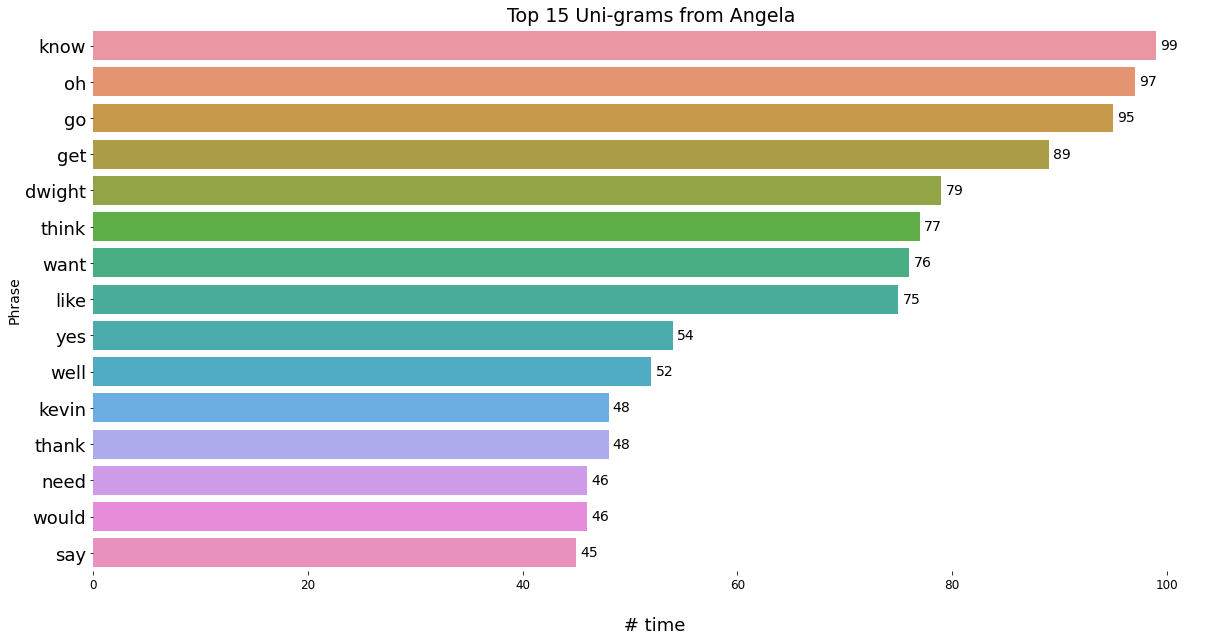

In [42]:
Angela_df=ngram_df[ngram_df.speaker.isin(['Angela'])]
creed_unigram = get_top_ngram(Angela_df['normalized_text_new'],1,15)
m1X, m1Y = map(list,zip(*creed_unigram))
n_gram_graph(m1Y,m1X,'Top 15 Uni-grams from Angela', '/Users/Nhu/Documents/Dev/The_Office/Figures/Angela_Uni_30.png')


In [57]:
michael_df_joke = office[office['speaker']=='Michael'].reset_index()

mcount =0
for i in range(0,len(michael_df_joke)):
    x = re.search('what she said',michael_df_joke['line_text_lower'][i])
    if type(x)==re.Match:
        mcount = mcount + 1


In [53]:
angela_cat = office[office['speaker']=='Angela'].reset_index()

# description_list=[]
# for description in angela_cat['line_text']:
#     #Tokenize
#     description=re.sub("[^a-zA-Z]", " ", description)
#     description=re.sub("\[[^)]*\]","",description)
#     description=description.lower()

#     description_list.append(description)
# angela_cat["lower"]=description_list
cat_count =0
cat_i=[]
for i in range(0,len(angela_cat)):
    x = re.search('cat',angela_cat['line_text_lower'][i])
    
    if type(x)==re.Match:
        cat_count = cat_count + 1
        cat_i.append(i)


# Topic Modeling


In [16]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [20]:
#Helpter functions
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
            
    return result

In [21]:
office['preprocessed'] = office['line_text'].map(preprocess)

### Emotion 
#### Reference https://www.kaggle.com/ruchi798/sentiment-analysis-the-simpsons/comments

In [60]:
from nrclex import NRCLex


In [61]:
#get emotion score using NRCLex
def get_emotion(data=None):
    text_object = NRCLex(' '.join(data))
    sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items())) 
    sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
    #sentiment_scores.sort_values(by=['Count'], ascending=False)
    return sentiment_scores.sort_values(by=['Count'], ascending=False)

In [62]:
whole_emotion = get_emotion(office['normalized_text_new'])

In [63]:
whole_emotion

,Sentiment,Count
2,positive,27192
6,negative,17718
4,trust,16705
0,anticipation,16456
1,joy,14530
5,fear,10186
3,surprise,9163
9,sadness,8442
7,anger,7683
8,disgust,5591


In [81]:
def get_emotion(data=None):
    text_object = NRCLex(' '.join(data))
    sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items())) 
    sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
    #sentiment_scores.sort_values(by=['Count'], ascending=False)
    sentiment_scores.sort_values(by=['Count'])
    return sentiment_scores

In [82]:
jim_new_df = get_emotion(jim_df['normalized_text_new'])
jim_new_df

,Sentiment,Count
0,positive,2489
1,anticipation,1682
2,joy,1356
3,trust,1514
4,negative,1543
5,anger,651
6,disgust,427
7,sadness,739
8,surprise,914
9,fear,929


In [83]:
sorter = ['positive',
 'anticipation',
 'joy',
 'trust',
 'negative',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'surprise']
def get_emotion_sorted(data=None):
    text_object = NRCLex(' '.join(data))
    sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items())) 
    sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
    #sentiment_scores.sort_values(by=['Count'], ascending=False)
    sentiment_scores.sort_values(by=['Count'])
#     sentiment_scores['Sentiment_cat']= pd.Categorical(sentiment_scores['Sentiment'], categories=sorter,ordered=True)
#     sentiment_scores.sort_values('Sentiment_cat')
    
    sentiment_scores['Sentiment'] = pd.Categorical(sentiment_scores['Sentiment'], sorter)
    
    return sentiment_scores.sort_values('Sentiment')

In [243]:
from matplotlib import cm
def pie_plot(data = None, title=None, location=None):
    lb = data['Sentiment']
    mys = sum(data['Count'])
    labels=[f'{np.round(y/mys*100,1)}% {lb[x]}' for x,y in data['Count'].items()]
    sizes = data['Count']
    # from matplotlib import cm
    #colors = ['#caff8a','#247ba0', '#e85d04', '#3da5d9', 'black','red', '#472d30', '#ff499e', '#f6ae2d', '#fdc5f5']
    
    #themes = plt.get_cmap('Blues')
    
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    # Plot
    plt.figure(figsize=(10,10))
    plt.pie(sizes, labels=labels, startangle=0,frame=False, textprops={'fontsize': 22})

    centre_circle = plt.Circle((0,0),0.8,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    #plt.title(title, fontsize=19, y=-0.1)
    plt.axis('equal')
    plt.tight_layout()
    #plt.savefig(location, bbox_inches='tight', transparent=True)
    plt.show()

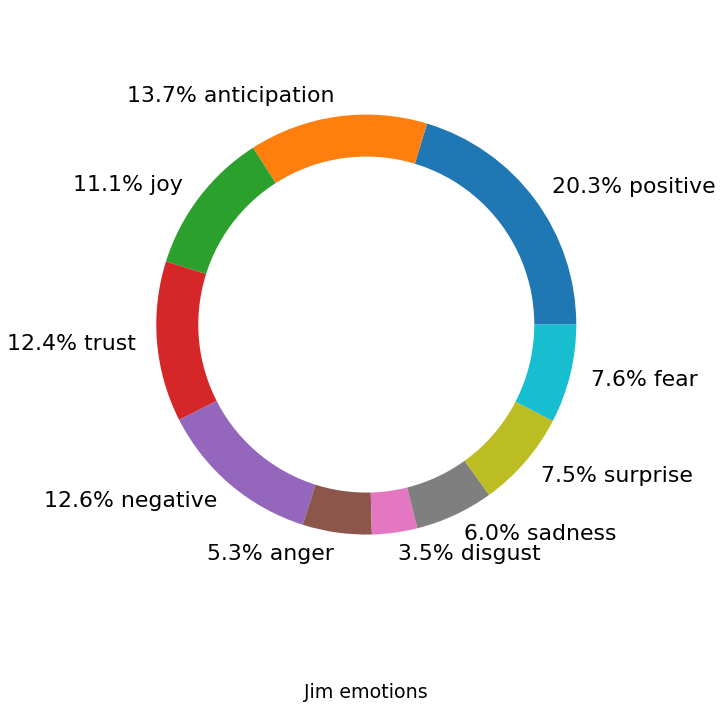

In [204]:
pie_plot(jim_new_df, 'Jim emotions', '/Users/Nhu/Documents/Dev/The_Office/Figures/Jim_emo.png')

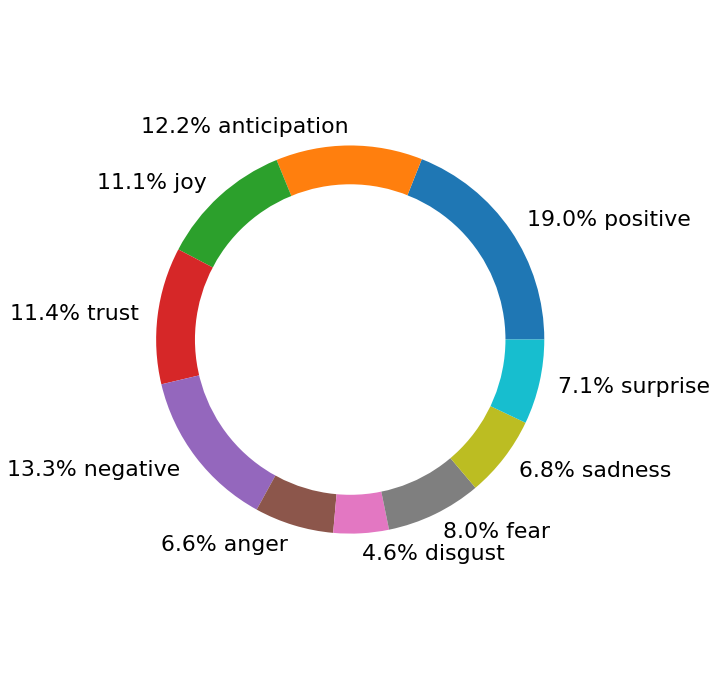

In [231]:
Michael_emo = office[office.speaker.isin(['Creed'])]
Michael_emo_df = get_emotion_sorted(Michael_emo['normalized_text_new'])
pie_plot(Michael_emo_df,'','/Users/Nhu/Documents/Dev/The_Office/Figures/Creed_emo.png')

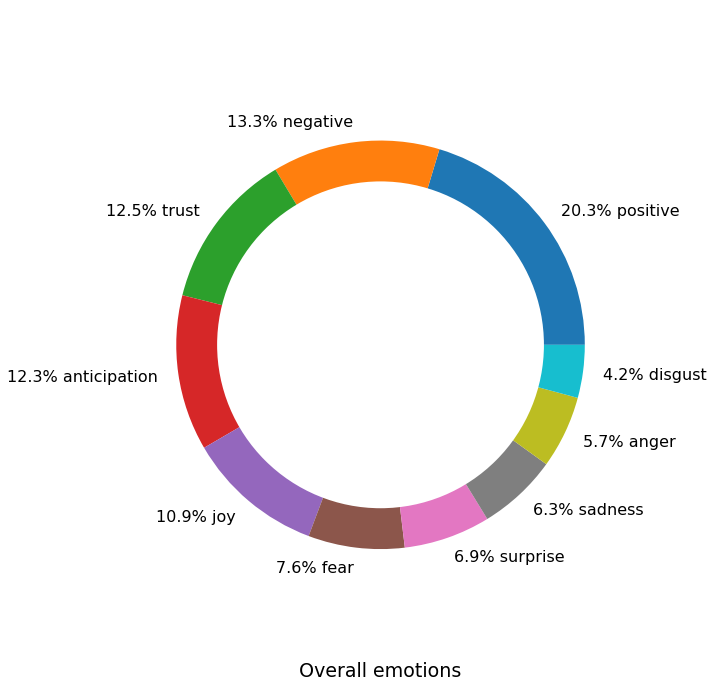

In [103]:
# angela_df = ngram_df[ngram_df.speaker.isin(['Angela'])]
# angela_emo_df = get_emotion_sorted(angela_df['normalized_text_new'])
pie_plot(whole_emotion, 'Overall emotions', '/Users/Nhu/Documents/Dev/The_Office/Figures/Overall_emo.png')

In [142]:
whole = whole_emotion.sort_values(by=['Count'])
whole['Sentiment'] = pd.Categorical(whole['Sentiment'], sorter)
whole = whole.sort_values('Sentiment')

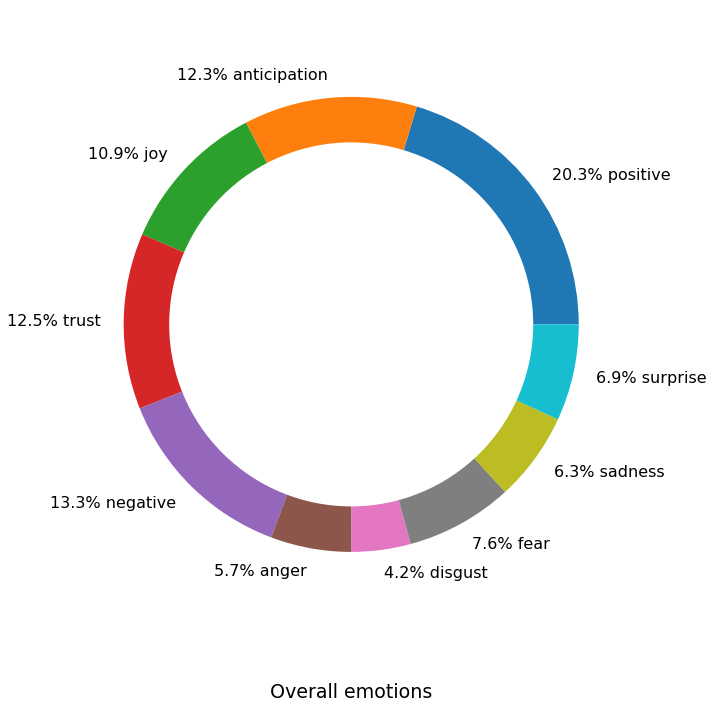

In [144]:
pie_plot(whole, 'Overall emotions', '/Users/Nhu/Documents/Dev/The_Office/Figures/Overall_emo.png')

In [233]:
def get_affected_frequency(data=None):
    text_object = NRCLex(' '.join(data))
    sentiment_scores = pd.DataFrame(list(text_object.affect_frequencies.items())) 
    sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
    #sentiment_scores.sort_values(by=['Count'], ascending=False)
    sentiment_scores.sort_values(by=['Count'])
#     sentiment_scores['Sentiment_cat']= pd.Categorical(sentiment_scores['Sentiment'], categories=sorter,ordered=True)
#     sentiment_scores.sort_values('Sentiment_cat')
    
   # sentiment_scores['Sentiment'] = pd.Categorical(sentiment_scores['Sentiment'], sorter)
    
    return sentiment_scores.sort_values('Sentiment')

In [235]:
aff_freq= get_affected_frequency(Michael_emo['normalized_text_new'])

In [239]:
aff_freq['Percentage'] = aff_freq['Count']*100


In [240]:
aff_freq

,Sentiment,Count,Percentage
1,anger,0.066004,6.600362
2,anticip,0.000000,0.000000
10,anticipation,0.122061,12.206148
8,disgust,0.046112,4.611212
0,fear,0.079566,7.956600
9,joy,0.111212,11.121157
6,negative,0.132911,13.291139
5,positive,0.189873,18.987342
7,sadness,0.067812,6.781193
4,surprise,0.070524,7.052441
